### Retailer Sales Data Forecasting

This dataset contains the daily sales data of a US retailer.  
Your objective is to forecast the total sales for each State over the next 12 months, using the historical data provided.


### Part 1: Top-Down Approach

1. **Aggregate Sales:**  
   Combine the sales data to create total sales at the `year-month` level, using the `Order Date` as the time variable for aggregation.


2. **Train a Model:**  
   Using the aggregated `year-month` data, train a model to forecast the total sales for the next 12 months.  
   *(The choice of model is up to you.)*

3. **Disaggregate Predictions:**  
   Split the predicted sales from the `year-month` level back to the `year-month-State` level.  
   *(The splitting strategy is up to you.)*

4. **Evaluate Accuracy:**  
   Assess the forecast accuracy at both the `year-month` and `year-month-State` levels.


# ____________________________________________________________

### Part 2: Alternative Approach

- Implement a different approach to forecast the next 12 months of sales at the `year-month-State` level.


# ____________________________________________________________

In [21]:
# Libraries

# Data handling and manipulation
import pandas as pd  
import numpy as np  

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Data visualization
import matplotlib.pyplot as plt  

# Data preprocessing
from sklearn.preprocessing import MinMaxScaler  # this scales data between a min and max value

# Deep learning framework
# Time series modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX  
from keras.models import Sequential  
from keras.layers import LSTM, Dense, Dropout  
from keras.optimizers import Adam



# ETL

In [2]:
# Load the dataset
df = pd.read_csv('Retailer Sales Data.csv')

# Convert 'Order Date' and 'Ship Date' columns to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')


In [3]:
# Print the number of missing values where both 'Ship Date' and 'Order Date' are missing
print("Number of missing values on 'Ship Date' and 'Order Date':", 
      df[df['Ship Date'].isnull() & df['Order Date'].isnull()].shape[0])

# Calculate shipping days as the difference between 'Ship Date' and 'Order Date'
df['Shipping_days'] = df['Ship Date'] - df['Order Date']

# Calculate the average shipping days
avg_shipping_days = df['Shipping_days'].mean()

# Impute missing 'Order Date' by subtracting the average shipping days from 'Ship Date'
df.loc[df['Order Date'].isnull(), 'Order Date'] = df['Ship Date'] - pd.to_timedelta(avg_shipping_days, unit='D')

# Drop rows where 'Order Date' is still missing
df = df[df['Order Date'].notna()]

# Create a new column 'Year-Month' for the order date at a monthly granularity
df['Year-Month'] = df['Order Date'].dt.to_period('M')

# Identify and print missing months in the dataset
missing_months = pd.period_range(start=df['Year-Month'].min(), 
                                 end=df['Year-Month'].max(), 
                                 freq='M').difference(df['Year-Month'])
print("Missing months of sales:", missing_months)

# Clean up by removing the temporary variable
del avg_shipping_days


Number of missing values on 'Ship Date' and 'Order Date': 14
Missing months of sales: PeriodIndex([], dtype='period[M]')


In [4]:
# Print number of rows with missing 'Sales' and 'Sub-Category'
print("Number of missing values on 'Sales' and 'Sub-Category':", 
      df[['Sales', 'Sub-Category']].isnull().all(axis=1).sum())

# Calculate average sales by 'Sub-Category' and 'Category'
avg_sales_sub_cat = df.groupby('Sub-Category')['Sales'].mean()
avg_sales_cat = df.groupby('Category')['Sales'].mean()

# Impute missing 'Sales' with average sales by 'Sub-Category' and 'Category'
df['Sales'] = df['Sales'].fillna(df['Sub-Category'].map(avg_sales_sub_cat))
df['Sales'] = df['Sales'].fillna(df['Category'].map(avg_sales_cat))

# Drop rows with still missing 'Sales'
df.dropna(subset=['Sales'], inplace=True)

# Clean up
del avg_sales_cat


Number of missing values on 'Sales' and 'Sub-Category': 23


In [5]:
# Check if any 'Customer ID' has more than one 'Customer Name'
print((df.groupby('Customer ID')['Customer Name'].nunique() > 1).sum())

# Create a dictionary to map 'Customer ID' to the first non-null 'State'
state_fill_dict = df.dropna(subset=['State']).groupby('Customer ID')['State'].first().to_dict()

# Fill missing 'State' values based on 'Customer ID'
df['State'] = df['State'].fillna(df['Customer ID'].map(state_fill_dict))

# Create a dictionary to map 'Country' to the first non-null 'State'
city_fill_dict = df.dropna(subset=['State', 'Country']).groupby('Country')['State'].first().to_dict()

# Fill remaining missing 'State' values based on 'Country'
df.loc[df['State'].isna() & df['Country'].notna(), 'State'] = df['Country'].map(city_fill_dict)

# Drop rows where 'State' is still missing
df.dropna(subset=['State'], inplace=True)

# Check for any remaining missing values in 'State'
print(df['State'].isna().sum())

# Clean up
del city_fill_dict
del state_fill_dict


0
0


In [6]:
print(df['Product ID'].isna().sum())
# Create a dictionary to map 'Customer ID' to the first non-null 'State'
product_fill_dict = df.dropna(subset=['Product ID']).groupby('Product Name')['Product ID'].first().to_dict()

# Fill missing 'State' values based on 'Customer ID'
df['Product ID'] = df['Product ID'].fillna(df['Product Name'].map(product_fill_dict))

print(df['Product ID'].isna().sum())
df.dropna(subset=['Product ID'], inplace=True)
print(df['Product ID'].isna().sum())

print('-')
print(df['Sub-Category'].isna().sum())
# Create a dictionary to map 'Customer ID' to the first non-null 'State'
sub_cat_fill_dict = df.dropna(subset=['Sub-Category']).groupby('Product Name')['Sub-Category'].first().to_dict()
product_id_fill_dict = df.dropna(subset=['Sub-Category']).groupby('Product ID')['Sub-Category'].first().to_dict()

# Fill missing 'State' values based on 'Customer ID'
df['Sub-Category'] = df['Sub-Category'].fillna(df['Product Name'].map(sub_cat_fill_dict))
df['Sub-Category'] = df['Sub-Category'].fillna(df['Product ID'].map(product_id_fill_dict))


print(df['Sub-Category'].isna().sum())
df.dropna(subset=['Sub-Category'], inplace=True)
print(df['Sub-Category'].isna().sum())


447
31
0
-
480
10
0


# ____________________________________________________________

# Modeling - Top Down Approach (Part 1)

### SARIMA


##### Year - Month Level

In [ ]:
# Group sales data by 'Year-Month' and 'State', then sum the sales
monthly_sales_state = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()

# Aggregate sales by 'Year-Month'
monthly_sales = monthly_sales_state.groupby(['Year-Month'])['Sales'].sum()

# Pivot the sales data to get sales by 'State' in columns
sales_by_state = monthly_sales_state.groupby(['Year-Month', 'State'])['Sales'].sum().unstack().fillna(0)

# Calculate the proportion of sales by state for each month
state_proportions = sales_by_state.div(sales_by_state.sum(axis=1), axis=0)

# Split the data into training and test sets based on date
train_data = monthly_sales[monthly_sales.index < '2018-01']
test_data = monthly_sales[monthly_sales.index >= '2018-01']



In [ ]:

# Define SARIMA model parameters
p, d, q = 1, 1, 1  # ARIMA parameters
P, D, Q, s = 1, 1, 1, 12  # Seasonal parameters (s=12 for monthly data)

# Train the SARIMA model
model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)


#####  Model Evaluation at Year - Month Level

In [ ]:
# Make forecasts for the next 12 periods
forecast = model_fit.get_forecast(steps=12)
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Create a Series for forecasted values
forecast_index = pd.period_range(start='2018-01', periods=12, freq='M')
forecast_series = pd.Series(forecast_values, index=forecast_index)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index.to_timestamp(), train_data, label='Training Data', color='blue')
plt.plot(test_data.index.to_timestamp(), test_data, label='Actual Data', color='green')
plt.plot(forecast_series.index.to_timestamp(), forecast_series, label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast_series.index.to_timestamp(), 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='red', alpha=0.3)
plt.title('Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Evaluate forecast accuracy using MSE, RMSE, and MAE
mse = mean_squared_error(test_data, forecast_series)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data, forecast_series)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


##### Year - Month proportioned by States

In [ ]:

# Create a DataFrame to hold proportionally forecasted values for each state
forecast_proportioned = pd.DataFrame(index=forecast_series.index, columns=state_proportions.columns)

# Allocate the total forecasted values proportionally across states
for state in state_proportions.columns:
    forecast_proportioned[state] = forecast_series * state_proportions[state]


#####  Model Evaluation at Year - Month  - states Level

In [ ]:
# Reconstruct the actual test data for each state based on historical proportions
test_data_state = pd.DataFrame(index=test_data.index, columns=state_proportions.columns)

# Multiply the total test data by the historical proportions for each state
for state in state_proportions.columns:
    test_data_state[state] = test_data * state_proportions[state]

    from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Prepare a list to store the results
results = []

# Calculate metrics for each state
for state in forecast_proportioned.columns:
    actual_data = test_data_state[state]  # Actual data for the state
    forecast_data = forecast_proportioned[state]  # Forecasted data for the state
    
    mse = mean_squared_error(actual_data, forecast_data)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_data, forecast_data)
    
    # Append results to the list
    results.append({
        'State': state,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    })
    
# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('sarima_state_metrics.csv', index=False)



In [ ]:
# Ensure the index of forecast_proportioned is in PeriodIndex format and convert if necessary
if isinstance(forecast_proportioned.index, pd.PeriodIndex):
    # Convert PeriodIndex to Timestamp for output
    forecast_proportioned.index = forecast_proportioned.index.to_timestamp()
else:
    # Convert non-periodic index to PeriodIndex first, then to Timestamp
    forecast_proportioned.index = pd.to_datetime(forecast_proportioned.index).to_period('M').to_timestamp()

# Reset index to long format for pivoting
forecast_long = forecast_proportioned.reset_index()

# Convert the DataFrame to long format (pivot)
forecast_long = pd.melt(forecast_long, id_vars=['index'], var_name='State', value_name='Sales')

# Rename 'index' column to 'Year-Month'
forecast_long.rename(columns={'index': 'Year-Month'}, inplace=True)

# Ensure 'Year-Month' is in datetime format
forecast_long['Year-Month'] = pd.to_datetime(forecast_long['Year-Month'], format='%Y-%m')


In [ ]:
# Aggregate actual sales data
actualsales = df.groupby(['Year-Month', 'State'])['Sales'].sum().reset_index()

# Convert 'Year-Month' tao PeriodIndex for merging
forecast_long['Year-Month'] = forecast_long['Year-Month'].dt.to_period('M')

# Rename columns for clarity
forecast_long.rename(columns={'Sales': 'Sales_Prediction'}, inplace=True)
actualsales.rename(columns={'Sales': 'Sales_Actual'}, inplace=True)

# Merge forecasted and actual sales data
prediction_and_actuals = forecast_long.merge(actualsales, on=['Year-Month', 'State'], how='left')

# Replace NaN values in 'Sales_Actual' with 0
prediction_and_actuals['Sales_Actual'] = prediction_and_actuals['Sales_Actual'].fillna(0)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert 'Year-Month' to datetime format for plotting
# If 'Year-Month' is already a PeriodIndex, convert it to Timestamp
if pd.api.types.is_period_dtype(prediction_and_actuals['Year-Month']):
    prediction_and_actuals['Year-Month'] = prediction_and_actuals['Year-Month'].dt.to_timestamp()
else:
    prediction_and_actuals['Year-Month'] = pd.to_datetime(prediction_and_actuals['Year-Month'], format='%Y-%m')

# Create a directory to save figures
output_dir = 'sarima_state_sales_figures'
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique states
states = prediction_and_actuals['State'].unique()

# Generate and save a plot for each state
for state in states:
    # Filter data for the current state
    state_data = prediction_and_actuals[prediction_and_actuals['State'] == state]
    
    # Set 'Year-Month' as the index
    state_data.set_index('Year-Month', inplace=True)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(state_data.index, state_data['Sales_Prediction'], label='Sales Prediction', marker='o')
    plt.plot(state_data.index, state_data['Sales_Actual'], label='Sales Actual', marker='o')
    plt.title(f'Sales Prediction vs Actual Sales for {state}')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to the specified directory
    file_path = os.path.join(output_dir, f'{state}_sales.png')
    plt.savefig(file_path)
    plt.close()  # Close the figure to free up memory

print(f'Figures saved in the directory: {output_dir}')


# ____________________________________________________________

### XGBOOST


# ____________________________________________________________

# Modeling - Bottom-Up Approach (Part 2)

In [8]:

# Aggregate sales by Year-Month, State, and Sub-Category
df_encoded = df.groupby(['Year-Month', 'State', 'Sub-Category'])['Sales'].sum().reset_index()

#* ######## One-hot encode ############
df_encoded = pd.get_dummies(df_encoded, columns=['Sub-Category', 'State'], drop_first=True)
#* ######## ###############  ##########

# Set 'Year-Month' as index
df_encoded.set_index('Year-Month', inplace=True)

# 3. Extract columns for scaling
features_to_scale = df_encoded[['Sales']]

# Very impotart -   MinMaxScaler to 0 to 1 range - avoiding high values
sales = features_to_scale.values.reshape(-1, 1)
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(sales)

# Convert scaled data back to DataFrame
scaled_df = pd.DataFrame(sales_scaled, columns=['Sales'], index=df_encoded.index)

# Add encoded columns (dummies) to the scaled DataFrame
scaled_df = pd.concat([scaled_df, df_encoded.drop(['Sales'], axis=1)], axis=1)


In [9]:

#* ######## Create training, validation, and test sets ######### 
# Training set up to 01 2017
train_data = scaled_df[scaled_df.index < '2017-01']

# Validation set from 01 2017 to 12 2017
val_data = scaled_df[(scaled_df.index >= '2017-01') & (scaled_df.index <= '2017-12')]

# Test set for 2018
test_data = scaled_df[scaled_df.index >= '2018-01']

##################################
y_train = train_data['Sales'].values
y_val = val_data['Sales'].values
y_test = test_data['Sales'].values  
##################################

##################################
X_train = train_data.drop(['Sales'], axis=1).values
X_val = val_data.drop(['Sales'], axis=1).values
X_test = test_data.drop(['Sales'], axis=1).values  # Test set
##################################

################################## (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # Reshape test set
##################################

##################################
# y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
##################################

In [17]:
print(min(y_val), min(y_test), min(y_train))
print(max(y_val), max(y_test), max(y_train))

1.7315989779325377e-05 0.0 1.8022764872359068e-05
0.7730134363245998 0.6184068264579134 1.0


In [13]:

#* ####################################################
#* ############ Create the LSTM model ################
model = Sequential()  
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) 

model.add(Dropout(0.2)) 
model.add(LSTM(units=100, return_sequences=False))  # do not return sequences as it's the last LSTM layer

model.add(Dropout(0.3))  # Add another dropout layer
model.add(Dense(units=1))  # Add a Dense layer with 1 unit for output
#* ####################################################
#* ####################################################


# Learning rate for the optimizer
learning_rate = 0.0001  
optimizer = Adam(learning_rate=learning_rate) 


#* ################ Compile and train the model ################
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val))  


Epoch 1/100


2024-09-29 17:07:28.955224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 17:07:29.210618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 17:07:29.520731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 17:07:29.721087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/78 [..............................] - ETA: 2:42 - loss: 8.3229e-04 - mae: 0.0154

2024-09-29 17:07:29.869312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 0.0014 - mae: 0.0167

2024-09-29 17:07:31.260518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 17:07:31.339885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 17:07:31.389743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 4s 23ms/step - loss: 0.0014 - mae: 0.0167 - val_loss: 0.0015 - val_mae: 0.0170
Epoch 2/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0013 - mae: 0.0160 - val_loss: 0.0014 - val_mae: 0.0159
Epoch 3/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0152 - val_loss: 0.0014 - val_mae: 0.0156
Epoch 4/100
78/78 [==============================] - 1s 15ms/step - loss: 0.0012 - mae: 0.0149 - val_loss: 0.0014 - val_mae: 0.0157
Epoch 5/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0149 - val_loss: 0.0013 - val_mae: 0.0154
Epoch 6/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0012 - mae: 0.0148 - val_loss: 0.0013 - val_mae: 0.0149
Epoch 7/100
78/78 [==============================] - 1s 12ms/step - loss: 0.0012 - mae: 0.0147 - val_loss: 0.0013 - val_mae: 0.0149
Epoch 8/100
78/78 [==============================] - 1s 13ms/step - loss: 0.0011 - mae: 

2024-09-29 17:09:10.632648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 17:09:10.701401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-09-29 17:09:10.759898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


47/47 [==============================] - 1s 3ms/step


In [14]:
test_loss, test_mae = model.evaluate(X_val, y_val)
print(f'Test Loss: {test_loss}')
print(f'Test MAE: {test_mae}')


47/47 [==============================] - 1s 10ms/step - loss: 0.0013 - mae: 0.0146
Test Loss: 0.001263165264390409
Test MAE: 0.014582477509975433


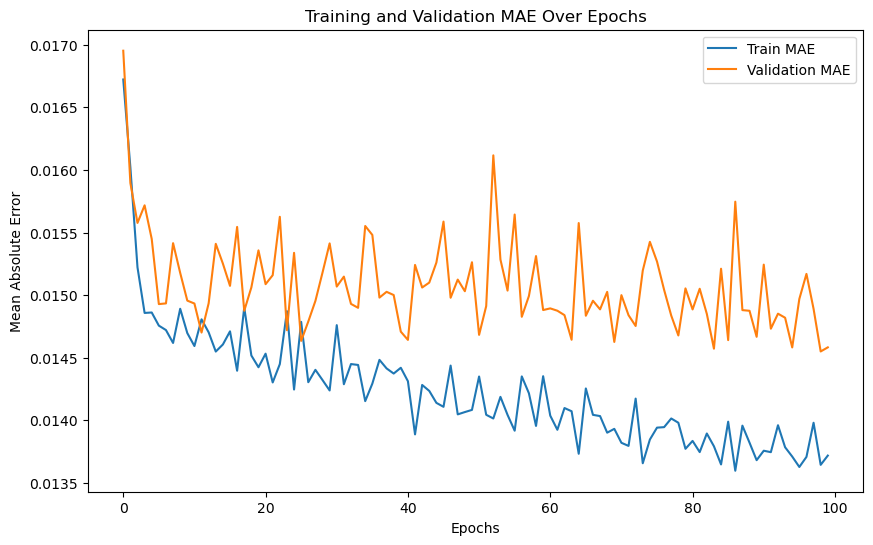

In [18]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Train MAE')  
plt.plot(history.history['val_mae'], label='Validation MAE')  
plt.title('Training and Validation MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


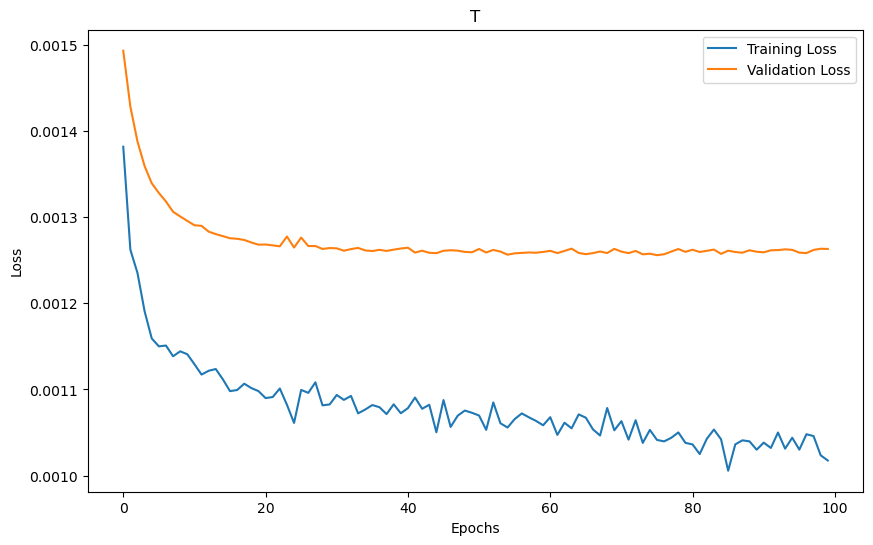

In [19]:

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')  
plt.plot(history.history['val_loss'], label='Validation Loss')  
plt.title('T')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)  # Generate predictions using the trained model on the test data

# Inverse scaling of predictions and actual values
# Combine features and predicted values, then inverse transform to get original scale
y_pred_test_inverse = scaler.inverse_transform(np.hstack((X_test.reshape(X_test.shape[0], -1), y_pred_test)))
y_test_inverse = scaler.inverse_transform(np.hstack((X_test.reshape(X_test.shape[0], -1), y_test.reshape(-1, 1))))

# Create a DataFrame for the predicted and actual sales
predictions_df = pd.DataFrame({
    'Year-Month': test_data.index,  # Use the index from the test data for the Year-Month
    'Real Sales': y_test_inverse[:, -1],  # Last column for 'Sales' values
    'Predicted Sales': y_pred_test_inverse[:, -1]  # Last column for predicted 'Sales'
})

#* ############## Convert dummy columns to categorical columns
#* ######################################################################

state_columns = [col for col in test_data.columns if 'State_' in col]  # Identify state dummy columns
sub_cat_columns = [col for col in test_data.columns if 'Sub-Category_' in col]  # Identify sub-category dummy columns

dummy_data = test_data[state_columns + sub_cat_columns]  # Extract dummy columns
decoded_data = pd.DataFrame(scaler.inverse_transform(dummy_data), columns=dummy_data.columns)  # Inverse scale the dummy data

decoded_data['State'] = decoded_data[state_columns].idxmax(axis=1).str.replace('State_', '')  # Get the original state names
decoded_data['Sub-Category'] = decoded_data[sub_cat_columns].idxmax(axis=1).str.replace('Sub-Category_', '')  # Get the original sub-category names

#* ######################################################################
#* ######################################################################

# Add 'State' and 'Sub-Category' columns to the predictions DataFrame
predictions_df = pd.concat([predictions_df, decoded_data[['State', 'Sub-Category']]], axis=1)

# 1. Group the original DataFrame df by Year-Month, State, and Sub-Category and sum sales
df_grouped = df.groupby(['Year-Month', 'State', 'Sub-Category'])['Sales'].sum().reset_index()  # Aggregate sales data

# Merge the predictionsaFr with the aggregated data
predictions_df = predictions_df.merge(df_grouped, on=['Year-Month', 'State', 'Sub-Category'], how='left', suffixes=('', '_agg'))

predictions_df.rename(columns={'Sales': 'Aggregated Sales'}, inplace=True)  # Rename the sales column for clarity


55/55 [==============================] - 1s 8ms/step
     Year-Month  Real Sales  Predicted Sales       State Sub-Category  \
0       2018-01      15.470        60.087093     Arizona          Art   
1       2018-01      40.900       284.558411     Arizona      Binders   
2       2018-01      95.984       260.150543     Arizona   Appliances   
3       2018-01       4.938       277.209808     Arizona      Binders   
4       2018-01     256.560       562.626709  California   Appliances   
...         ...         ...              ...         ...          ...   
1731    2018-12     459.920       616.594604   Wisconsin    Bookcases   
1732    2018-12      99.950       129.339706   Wisconsin  Furnishings   
1733    2018-12      61.060        55.285309   Wisconsin       Labels   
1734    2018-12      27.520        76.576012   Wisconsin        Paper   
1735    2018-12      32.560       373.044739   Wisconsin      Storage   

      Aggregated Sales  
0                  NaN  
1                4.9

In [58]:

# Group by 'State' and 'Year-Month' 
grouped_predictions = predictions_df.groupby(['State', 'Year-Month']).agg({
    'Real Sales': 'sum',  
    'Predicted Sales': 'sum' 
}).reset_index()  

# Calculate accuracy as a percentage of predicted sales to real sales
grouped_predictions['Accuracy'] = grouped_predictions['Predicted Sales'] / grouped_predictions['Real Sales']

# Handle any division by zero cases
# Replace infinite values with NaN and then fill NaN with 0
grouped_predictions['Accuracy'].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf/-inf with NaN
grouped_predictions['Accuracy'].fillna(0, inplace=True)  # Fill NaN with 0 to avoid any invalid accuracy

# Print the DataFrame with real sales, predicted sales, and accuracy
print(grouped_predictions)  # Display the grouped predictions DataFrame


         State Year-Month   Real Sales  Predicted Sales  Accuracy
0      Arizona    2018-01   157.292000      1065.279419  6.772623
1      Arizona    2018-02  1112.044723      1788.965210  1.608717
2      Arizona    2018-04  1079.056000      1561.061523  1.446692
3      Arizona    2018-05  1114.123897      2136.491699  1.917643
4      Arizona    2018-06   951.548000      2041.188354  2.145124
..         ...        ...          ...              ...       ...
344  Wisconsin    2018-08   113.410000       350.500244  3.090559
345  Wisconsin    2018-09   312.610167      1345.802124  4.305049
346  Wisconsin    2018-10    60.720000       222.086044  3.657544
347  Wisconsin    2018-11   442.262750      1192.234131  2.695760
348  Wisconsin    2018-12  2020.770345      1946.409668  0.963202

[349 rows x 5 columns]


In [22]:

grouped_predictions = predictions_df.groupby(['State', 'Year-Month']).agg({
    'Real Sales': 'sum',  
    'Predicted Sales': 'sum' 
}).reset_index()  

# Calcola le metriche
mse = mean_squared_error(grouped_predictions['Real Sales'], grouped_predictions['Predicted Sales'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(grouped_predictions['Real Sales'], grouped_predictions['Predicted Sales'])
r_squared = r2_score(grouped_predictions['Real Sales'], grouped_predictions['Predicted Sales'])

# Stampa i risultati
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r_squared:.4f}")


Mean Squared Error (MSE): 4434038.3141
Root Mean Squared Error (RMSE): 2105.7156
Mean Absolute Error (MAE): 1072.2502
R-squared (R²): 0.6162


In [63]:

# Convert 'Year-Month' to datetime format for plotting
if pd.api.types.is_period_dtype(grouped_predictions['Year-Month']):
    grouped_predictions['Year-Month'] = grouped_predictions['Year-Month'].dt.to_timestamp()
else:
    grouped_predictions['Year-Month'] = pd.to_datetime(grouped_predictions['Year-Month'], format='%Y-%m')

# Create a directory to save figures
output_dir = 'lstm_state_sales_figures'
os.makedirs(output_dir, exist_ok=True)

# Get the list of unique states
states = grouped_predictions['State'].unique()

# Generate and save a plot for each state
for state in states:
    # Filter data for the current state
    state_data = grouped_predictions[grouped_predictions['State'] == state]
    
    # Set 'Year-Month' as the index
    state_data.set_index('Year-Month', inplace=True)
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(state_data.index, state_data['Predicted Sales'], label='Sales Prediction', marker='o', color='blue')
    plt.plot(state_data.index, state_data['Real Sales'], label='Sales Actual', marker='o', color='orange')
    plt.title(f'Sales Prediction vs Actual Sales for {state}')
    plt.xlabel('Year-Month')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to the specified directory
    file_path = os.path.join(output_dir, f'{state}_sales.png')
    plt.savefig(file_path)
    plt.close()  # Close the figure to free up memory

print(f'Figures saved in the directory: {output_dir}')


Figures saved in the directory: lstm_state_sales_figures
